In [1]:
import os

from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
import random
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [2]:
log_path = './log/'+datetime.now().strftime('%Y-%m-%d_%H-%M-%S')+'/'
os.mkdir(log_path)
seed = 20510099
rng = torch.Generator().manual_seed(seed)
random.seed(seed)
parallel_cuda = [0, 2, 3]
model_cuda = 0
bs = 128

### Data preprocessing

In [3]:
def show_images(files, labels=None):
    if len(files) == 0: return
    if not ('jpg' in files[0]):
        filenames = ['Image_'+file+'.jpg' for file in files]
    else:
        filenames = files

    imgs = [Image.open('./data/images/'+filename) for filename in filenames]
    plot_images(imgs, labels)

def plot_images(imgs, labels=None, transform=T.Compose([])):
    fig, ax = plt.subplots(2, 3)
    fig.set_figwidth(15)
    fig.set_figheight(8)
    k = 0
    for j in range(2):
        for i in range(3):
            if labels:
                ax[j][i].set_title(labels[k])
            ax[j][i].imshow(transform(imgs[k]))
            k += 1
    plt.show()

Raw: 5400 (Burger: 1800, Pizza:1800, Softdrink: 1800)


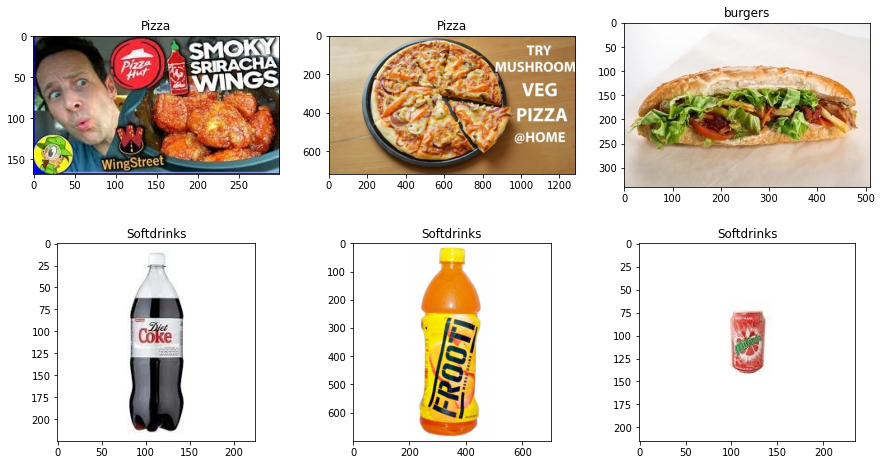

In [4]:
raw_df = pd.read_csv('./data/data.csv')
print("Raw: %4d (Burger: %4d, Pizza:%4d, Softdrink: %4d)" 
        % (len(raw_df), np.sum(raw_df.label == 'burgers'), np.sum(raw_df.label == 'Pizza'), np.sum(raw_df.label == 'Softdrinks')))

samples = raw_df.sample(n=6, random_state=seed)
show_images(samples['filename'].tolist(), samples['label'].tolist())
del samples

# of bad data: 1078 (burger: 269, pizza: 372, soda: 437)
Burger:


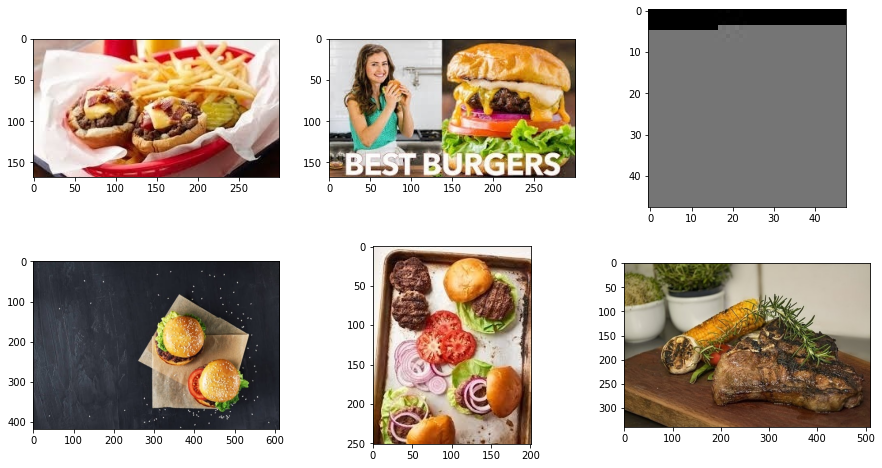

Pizza:


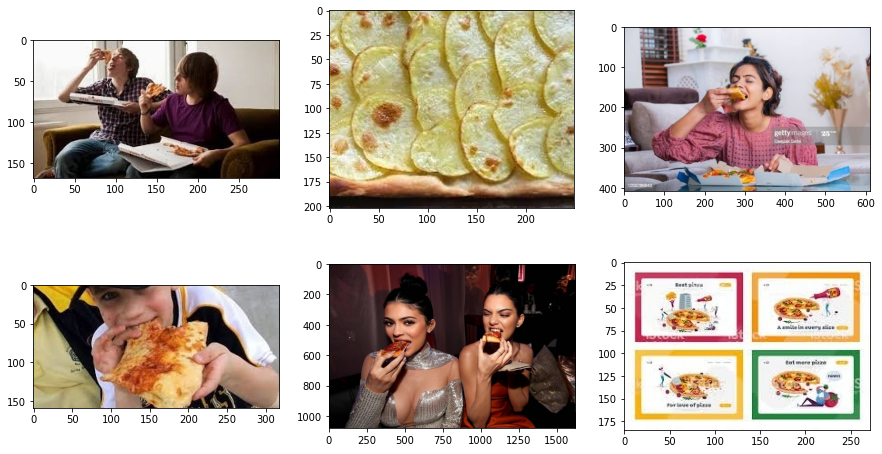

Soda:


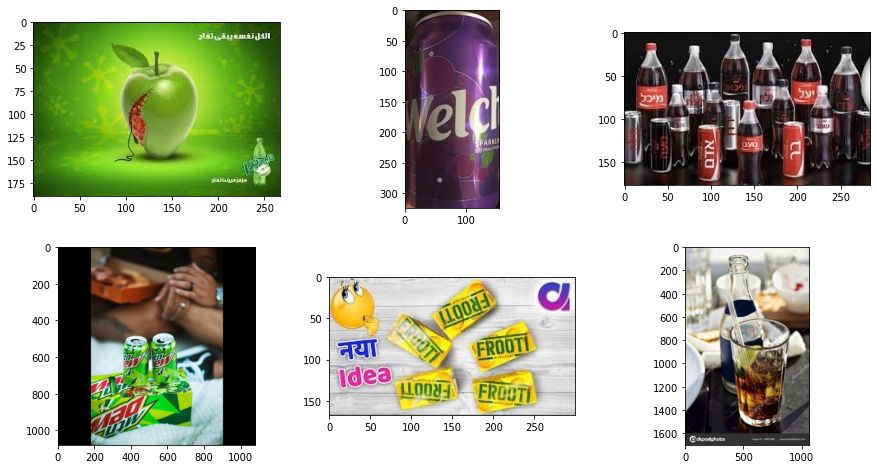

In [5]:
def delete_bad_image(bad_lists):
    for i in bad_lists:
        path = './data/images/Image_'+i+'.jpg'
        if os.path.exists(path):
            print('removing Image_'+i+'.jpg')
            os.remove(path)

bad_burger_list = open("./data/bad/burger.txt", "r").readline().split(',')
bad_pizza_list = open("./data/bad/pizza.txt", "r").readline().split(',')
bad_soda_list = open("./data/bad/soda.txt", "r").readline().split(',')
bad_data = np.array(bad_burger_list + bad_pizza_list + bad_soda_list)
print("# of bad data: %4d (burger: %3d, pizza: %3d, soda: %3d)" % (len(bad_data), len(bad_burger_list), len(bad_pizza_list), len(bad_soda_list)))

print("Burger:")
show_images(random.sample(bad_burger_list, 6))

print("Pizza:")
show_images(random.sample(bad_pizza_list, 6))

print("Soda:")
show_images(random.sample(bad_soda_list, 6))

Processed: 4323 (Burger: 1532, Pizza:1425, Softdrink: 1366)


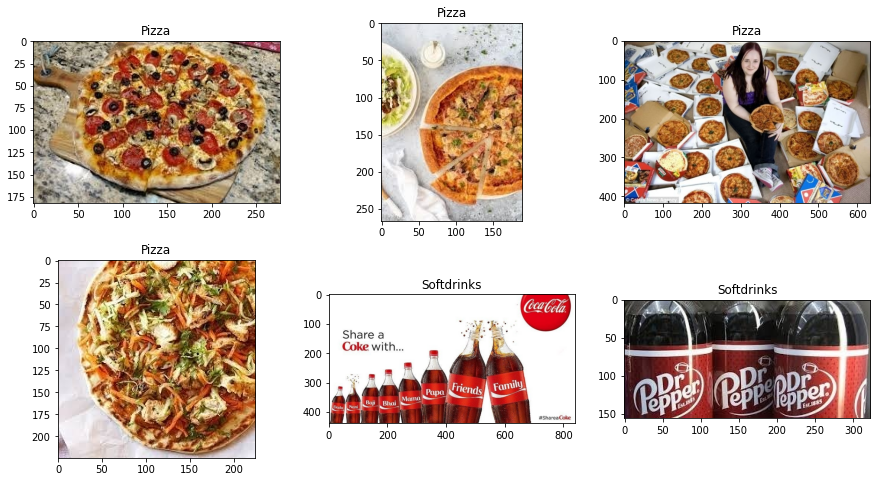

In [6]:
processed_df = raw_df.drop(bad_data.astype(int)-1, axis=0).reset_index(drop=True)
print("Processed: %4d (Burger: %4d, Pizza:%4d, Softdrink: %4d)" 
        % (len(processed_df), np.sum(processed_df.label == 'burgers'), np.sum(processed_df.label == 'Pizza'), np.sum(processed_df.label == 'Softdrinks')))

samples = processed_df.sample(n=6, random_state=seed)
show_images(samples['filename'].tolist(), samples['label'].tolist())
del samples

### Dataset and Dataloader

In [7]:
label_encoder = LabelEncoder().fit(pd.unique(processed_df.label))

class Food_Dataset(Dataset):
    def __init__(self, img_dir, df, transform=None):
        self.img_dir = img_dir
        self.X, self.y = df.filename, label_encoder.transform(df.label)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = Image.open(self.img_dir+self.X[idx])
        if self.transform:
            img = self.transform(img)
        label = self.y[idx]
        return img, label

In [8]:
transform = T.Compose([
    T.Resize(300),
    T.CenterCrop(200),
    T.ToTensor()])

train_transform = T.Compose([
    T.Resize(300),
    T.CenterCrop(200),
    T.AutoAugment(),
    T.ToTensor()])

train_df = processed_df.sample(frac=0.6)
non_train_df = processed_df.drop(train_df.index)
valid_df = non_train_df.sample(frac=0.75)
test_df = non_train_df.drop(valid_df.index)

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_set = Food_Dataset('./data/images/', train_df, train_transform)
valid_set = Food_Dataset('./data/images/', valid_df, transform)
test_set  = Food_Dataset('./data/images/', test_df,  transform)


print("Train: %4d (Burger: %4d, Pizza:%4d, Softdrink: %4d)" 
        % (len(train_df), np.sum(train_df.label == 'burgers'), np.sum(train_df.label == 'Pizza'), np.sum(train_df.label == 'Softdrinks')))
print("Valid: %4d (Burger: %4d, Pizza:%4d, Softdrink: %4d)" 
        % (len(valid_df), np.sum(valid_df.label == 'burgers'), np.sum(valid_df.label == 'Pizza'), np.sum(valid_df.label == 'Softdrinks')))
print("Test: %4d (Burger: %4d, Pizza:%4d, Softdrink: %4d)" 
        % (len(test_df), np.sum(test_df.label == 'burgers'), np.sum(test_df.label == 'Pizza'), np.sum(test_df.label == 'Softdrinks')))

Train: 2594 (Burger:  942, Pizza: 845, Softdrink:  807)
Valid: 1297 (Burger:  436, Pizza: 439, Softdrink:  422)
Test:  432 (Burger:  154, Pizza: 141, Softdrink:  137)


In [9]:
train_loader = DataLoader(train_set, bs, shuffle=True, generator=rng)
valid_loader = DataLoader(valid_set, bs, shuffle=True, generator=rng)
test_loader = DataLoader(test_set, bs, shuffle=True, generator=rng)

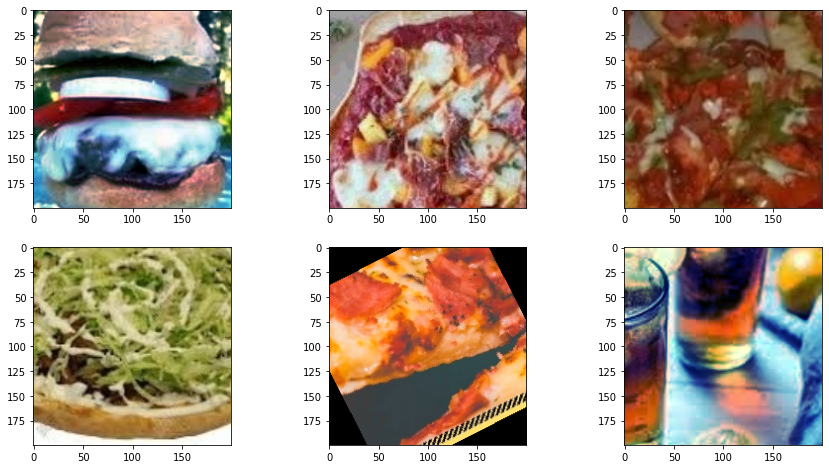

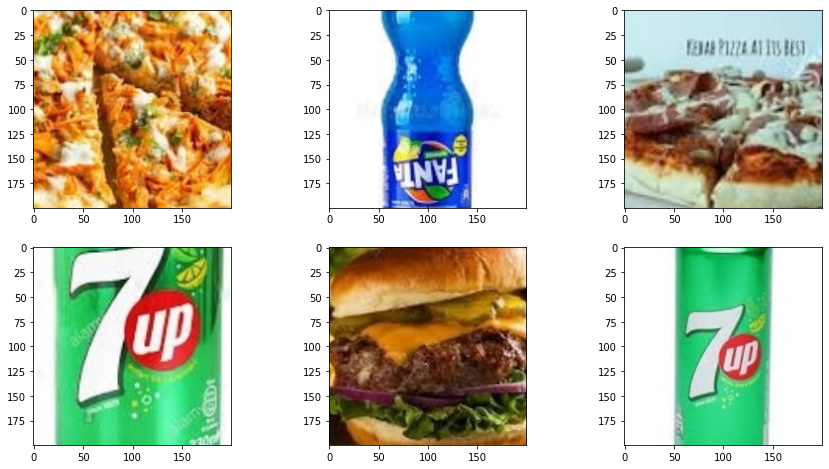

In [10]:
train_samples = next(iter(train_loader))[:6]
valid_samples = next(iter(valid_loader))[:6]
plot_images(train_samples[:][0], transform=T.Compose([T.ToPILImage()]))
plot_images(valid_samples[:][0], transform=T.Compose([T.ToPILImage()]))

### Model

In [11]:
class basic_1(nn.Module):
    def __init__(self, Cin, Cout, kernel_size):
        super(basic_1, self).__init__()
        self.conv2d = nn.Conv2d(Cin, Cout, kernel_size)
        self.bn = nn.BatchNorm2d(Cout)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, X):
        result = self.relu(self.bn(self.conv2d(X)))
        result = self.maxpool(result)
        return result

class basic_2(nn.Module):
    def __init__(self, Cin, Cout, kernel_size):
        super(basic_2, self).__init__()
        self.conv2d = nn.Conv2d(Cin, Cout, kernel_size)
        self.bn = nn.BatchNorm2d(Cout)
        self.relu = nn.LeakyReLU()

    def forward(self, X):
        result = self.relu(self.bn(self.conv2d(X)))
        return result

class Food_Model(nn.Module):
    def __init__(self):
        super(Food_Model, self).__init__()
        self.block1 = nn.Sequential(
            basic_1(3, 32, 3),
            basic_1(32, 64, 3),
            basic_2(64, 16, 1)
        )

        self.block2 = nn.Sequential(
            basic_1(16, 64, 3),
            basic_1(64, 128, 3),
            basic_2(128, 32, 1)
        )

        self.block3 = nn.Sequential(
            basic_1(32, 128, 3),
            basic_1(128, 256, 3),
            basic_2(256, 64, 1)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Linear(16, 3)

    def forward(self, X):
        result = self.block1(X)
        result = self.block2(result)
        result = self.block3(result)

        result = result.view(-1, 64)
        result = self.fc1(result)
        result = self.fc2(result)

        return result


In [12]:
temp_model = Food_Model()
print(summary(temp_model, (bs, 3, 200, 200), device='cuda:3'))
del temp_model

Layer (type:depth-idx)                   Output Shape              Param #
Food_Model                               --                        --
├─Sequential: 1-1                        [128, 16, 48, 48]         --
│    └─basic_1: 2-1                      [128, 32, 99, 99]         --
│    │    └─Conv2d: 3-1                  [128, 32, 198, 198]       896
│    │    └─BatchNorm2d: 3-2             [128, 32, 198, 198]       64
│    │    └─LeakyReLU: 3-3               [128, 32, 198, 198]       --
│    │    └─MaxPool2d: 3-4               [128, 32, 99, 99]         --
│    └─basic_1: 2-2                      [128, 64, 48, 48]         --
│    │    └─Conv2d: 3-5                  [128, 64, 97, 97]         18,496
│    │    └─BatchNorm2d: 3-6             [128, 64, 97, 97]         128
│    │    └─LeakyReLU: 3-7               [128, 64, 97, 97]         --
│    │    └─MaxPool2d: 3-8               [128, 64, 48, 48]         --
│    └─basic_2: 2-3                      [128, 16, 48, 48]         --
│    │   

### Training

In [12]:
def save_data(path, filename, data):
    if not os.path.exists(path+filename):
        file = open(path+filename, 'a')
        file.write('data\n')
    else:
        file = open(path+filename, 'a')

    for item in data:
        file.write(str(item)+'\n')
    file.close()

def train_phase(model, train_loader, criterion, optimizer):
    model.train()
    itr_loss = []
    epoch_loss = 0.0
    epoch_corrects = 0

    for inputs, labels in train_loader:
        # forward pass
        inputs, labels = inputs.cuda(model_cuda), labels.cuda(model_cuda)
        net = nn.DataParallel(model, device_ids=parallel_cuda)
        outputs = net(inputs)

        # count corrects
        preds = torch.argmax(outputs.data, dim=1)
        epoch_corrects += torch.sum(preds == labels.data)

        # calculate loss
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        itr_loss.append(loss.item())
        
        # backword pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # calculate epoch loss and acc
    epoch_loss = epoch_loss / len(train_loader)
    epoch_acc = epoch_corrects / float(len(train_loader.dataset))
    return epoch_loss, epoch_acc.item(), itr_loss

def valid_phase(model, valid_loader, criterion):
    with torch.no_grad():
        model.eval()
        itr_loss = []
        epoch_loss = 0.0
        epoch_corrects = 0

        for inputs, labels in valid_loader:
            # forward pass
            inputs, labels = inputs.cuda(model_cuda), labels.cuda(model_cuda)
            net = nn.DataParallel(model, device_ids=parallel_cuda)
            outputs = net(inputs)
            
            # count corrects
            preds = torch.argmax(outputs.data, dim=1)
            epoch_corrects += torch.sum(preds == labels.data)

            # calculate loss
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            itr_loss.append(loss.item())

        # calculate epoch loss and acc
        epoch_loss = epoch_loss / len(valid_loader)
        epoch_acc = epoch_corrects / float(len(valid_loader.dataset))
            
        return epoch_loss, epoch_acc.item(), itr_loss
        
def train_model(model, train_loader, valid_loader, num_epochs, criterion, optimizer):
    itr = [0, 0]
    best_loss = 10000.0
    for epoch in range(num_epochs):
        train_loss, train_acc, train_itr_loss = train_phase(model, train_loader, criterion, optimizer)
        valid_loss, valid_acc, valid_itr_loss = valid_phase(model, valid_loader, criterion)

        # save loss and acc
        save_data(log_path, 'train_epoch_loss.csv', [train_loss])
        save_data(log_path, 'train_epoch_acc.csv', [train_acc])
        save_data(log_path, 'train_itr_loss.csv', train_itr_loss)
        save_data(log_path, 'valid_epoch_loss.csv', [valid_loss])
        save_data(log_path, 'valid_epoch_acc.csv', [valid_acc])
        save_data(log_path, 'valid_itr_loss.csv', valid_itr_loss)

        # save best model
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), log_path+'best_model_params.pth')

        # write data to tensorboard
        for loss in train_itr_loss:
            writer.add_scalar("training loss vs iteration", loss, itr[0])
            itr[0] += 1
        for loss in valid_itr_loss:
            writer.add_scalar("validation loss vs iteration", loss, itr[1])
            itr[1] += 1
        writer.add_scalar("training loss vs epoch", train_loss, epoch)
        writer.add_scalar("validation loss vs epoch", valid_loss, epoch)
        
        # display result per 10 epoch
        if (epoch+1)%1 == 0:
            print('Epoch[{:2d}/{:2d}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
                  .format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))
    print("Finished Training")

In [13]:
model = Food_Model().cuda(model_cuda)
num_epochs = 50
criterion = nn.CrossEntropyLoss().cuda(model_cuda)
lr = 2e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

writer = SummaryWriter(log_path)

tic = time.time()
train_model(model, train_loader, valid_loader, num_epochs, criterion, optimizer)
toc = time.time()
save_data(log_path, 'start_end_time.csv', [tic, toc, toc-tic])
print('Total training time: {}s'.format(toc-tic))

Epoch[ 1/50], Train Loss: 1.0824, Train Acc: 0.4168, Valid Loss: 1.0977,  Valid Acc: 0.3666
Epoch[ 2/50], Train Loss: 0.9111, Train Acc: 0.5578, Valid Loss: 0.8400,  Valid Acc: 0.6218
Epoch[ 3/50], Train Loss: 0.8186, Train Acc: 0.6454, Valid Loss: 0.6207,  Valid Acc: 0.7932
Epoch[ 4/50], Train Loss: 0.7678, Train Acc: 0.6662, Valid Loss: 0.5648,  Valid Acc: 0.8332
Epoch[ 5/50], Train Loss: 0.7347, Train Acc: 0.7042, Valid Loss: 0.5662,  Valid Acc: 0.8009
Epoch[ 6/50], Train Loss: 0.6980, Train Acc: 0.7257, Valid Loss: 0.5013,  Valid Acc: 0.8401
Epoch[ 7/50], Train Loss: 0.6780, Train Acc: 0.7507, Valid Loss: 0.5377,  Valid Acc: 0.8240
Epoch[ 8/50], Train Loss: 0.6498, Train Acc: 0.7572, Valid Loss: 0.4655,  Valid Acc: 0.8655
Epoch[ 9/50], Train Loss: 0.6267, Train Acc: 0.7733, Valid Loss: 0.4671,  Valid Acc: 0.8809
Epoch[10/50], Train Loss: 0.6335, Train Acc: 0.7618, Valid Loss: 0.4622,  Valid Acc: 0.8640
Epoch[11/50], Train Loss: 0.6089, Train Acc: 0.7718, Valid Loss: 0.4354,  Valid 

### Evaluation and test

In [11]:
def plot_loss_acc(train_result, valid_result, xlabel, ylabel, title):
    plt.plot(range(len(train_result)), train_result, 'r-', range(len(valid_result)), valid_result, 'b-')
    plt.legend(('Train', 'Valid'))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def display_test_result(X, y, pred):
    toimg = T.Compose([T.ToPILImage()])
    fig, ax = plt.subplots(4, len(y)//4)
    fig.set_figwidth(20)
    fig.set_figheight(18)
    counter = 0

    gt = label_encoder.inverse_transform(y)
    est = label_encoder.inverse_transform(pred)
    for j in range(4):
        for i in range(len(y)//4):
            title = "GT: {}({})\n Pred:{}({})".format(gt[counter], y[counter], est[counter], pred[counter])
            ax[j, i].set_title(title)
            ax[j, i].imshow(toimg(X[counter]))
            counter += 1
    plt.show()

log_path = './log/2021-11-26_12-30-56/'
train_loss = pd.read_csv(log_path+'train_epoch_loss.csv')
train_itr_loss = pd.read_csv(log_path+'train_itr_loss.csv')
train_acc = pd.read_csv(log_path+'train_epoch_acc.csv')
valid_loss = pd.read_csv(log_path+'valid_epoch_loss.csv')
valid_itr_loss = pd.read_csv(log_path+'valid_itr_loss.csv')
valid_acc = pd.read_csv(log_path+'valid_epoch_acc.csv')

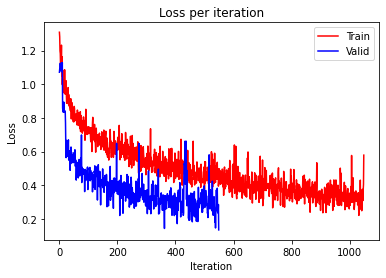

In [14]:
plot_loss_acc(train_itr_loss, valid_itr_loss, 'Iteration', 'Loss', 'Loss per iteration')

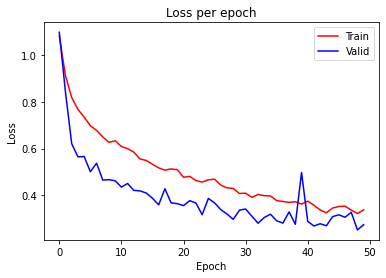

In [15]:
plot_loss_acc(train_loss, valid_loss, 'Epoch', 'Loss', 'Loss per epoch')

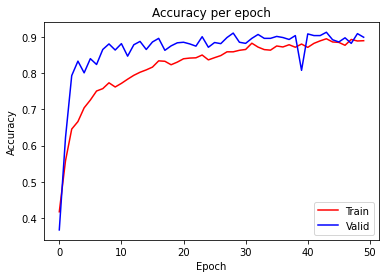

In [16]:
plot_loss_acc(train_acc, valid_acc, 'Epoch', 'Accuracy', 'Accuracy per epoch')

In [17]:
test_loader = DataLoader(test_set, len(test_set))
X_test, y_test = next(iter(test_loader))

In [18]:
model = Food_Model().cuda(model_cuda)
with torch.no_grad():
    model.eval()
    model.load_state_dict(torch.load(log_path+'best_model_params.pth'))
    y_pred = torch.argmax(model(X_test.cuda(model_cuda)).data, dim=1)
    save_data(log_path, 'test_y_test.csv', y_test.tolist())
    save_data(log_path, 'test_y_pred.csv', y_pred.tolist())

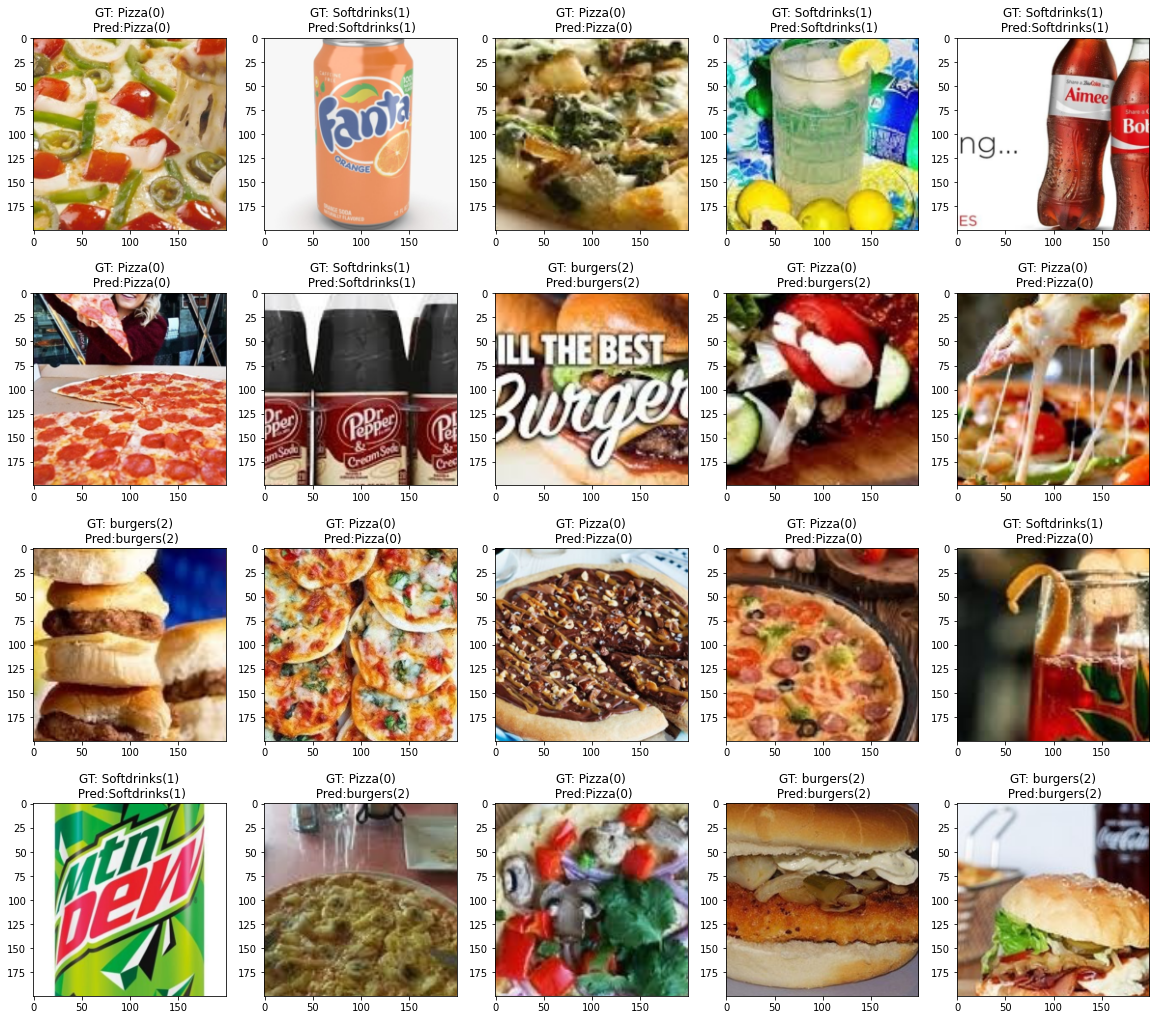

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       132
           1       0.97      0.98      0.98       140
           2       0.94      0.96      0.95       162

    accuracy                           0.95       434
   macro avg       0.95      0.95      0.95       434
weighted avg       0.95      0.95      0.95       434



In [21]:
samples_index = torch.randperm(len(y_test), generator=rng)[:20]
display_test_result(X_test[samples_index], y_test[samples_index], y_pred.cpu()[samples_index])
print(classification_report(y_test, y_pred.cpu(), labels=torch.unique(y_test, sorted=True), zero_division=0))

f:\python\virtualenv\py39_pytorch\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


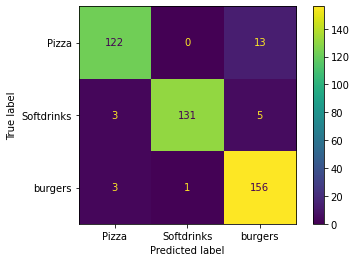

In [19]:
test_y_test = pd.read_csv(log_path+'test_y_test.csv')
test_y_pred = pd.read_csv(log_path+'test_y_pred.csv')
ConfusionMatrixDisplay.from_predictions(label_encoder.inverse_transform(test_y_test), label_encoder.inverse_transform(test_y_pred))
plt.show()